[INFO] Found 2189 images with 36 classes.
Model: "model_2"


d:\febri.dwi\anaconda3\envs\ws-cctv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                                                  
 expanded_

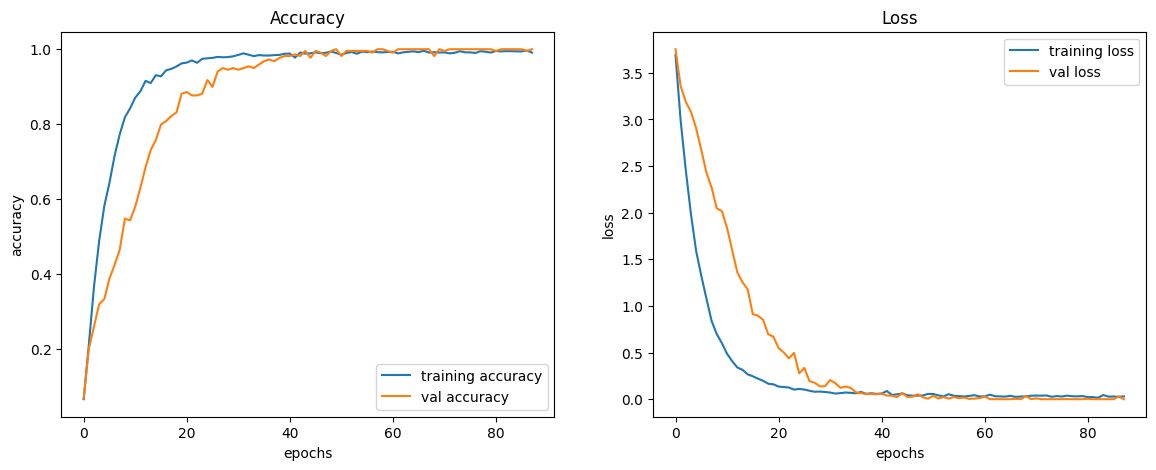

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Ignore warnings
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ.pop('TF_CONFIG', None)

import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import ssl

# TensorFlow GPU configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

ssl._create_default_https_context = ssl._create_unverified_context

class Train:
    def __init__(self, dataset_path, img_size=(80, 80), batch_size=64, epochs=30, lr=1e-4, output_dir=None):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model = None
        self.trainX = None
        self.testX = None
        self.trainY = None
        self.testY = None
        self.lb = None

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        self.output_dir = output_dir

    def load_dataset(self):
        dataset_paths = glob.glob(os.path.join(self.dataset_path, "**/*.*"), recursive=True)
        valid_extensions = [".jpg", ".jpeg", ".png"]

        X, labels = [], []

        for image_path in dataset_paths:
            if any(image_path.endswith(ext) for ext in valid_extensions):
                label = image_path.split(os.path.sep)[-2]
                image = tf.keras.utils.load_img(
                    image_path,
                    grayscale=False,
                    color_mode='rgb',
                    target_size=self.img_size,
                    interpolation='nearest'
                )
                # image = tf.keras.preprocessing.image.img_to_array(image_path, target_size=self.img_size)
                # image = tf.keras.preprocessing.image.img_to_array(image)
                X.append(image)
                labels.append(label)

        if len(X) == 0:
            print(f"[ERROR] No images found in the dataset path: {self.dataset_path}")
            return

        X = np.array(X, dtype="float16")
        labels = np.array(labels)

        print(f"[INFO] Found {len(X)} images with {len(set(labels))} classes.")
        self.lb = LabelEncoder()
        self.lb.fit(labels)
        labels = self.lb.transform(labels)
        y = tf.keras.utils.to_categorical(labels)

        np.save(os.path.join(self.output_dir, 'character_classes.npy'), self.lb.classes_)
        self.trainX, self.testX, self.trainY, self.testY = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

    def data_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                  shear_range=0.1, zoom_range=0.1, fill_mode="nearest")

    def create_model(self, lr=1e-4, decay=1e-4/25, training=True):        
        baseModel = tf.keras.applications.mobilenet_v2.MobileNetV2(
            weights="imagenet", 
            include_top=False,
            input_tensor=tf.keras.Input(shape=(80, 80, 3))
        )

        headModel = baseModel.output
        headModel = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(headModel)  # Now compatible with base model
        headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
        headModel = tf.keras.layers.Dense(64, activation="relu")(headModel)
        headModel = tf.keras.layers.Dropout(0.5)(headModel)
        headModel = tf.keras.layers.Dense(self.trainY.shape[1], activation="softmax")(headModel)

        self.model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

        if training:
            # define trainable lalyer
            for layer in baseModel.layers:
                layer.trainable = True
            # compile model
            optimizer = tf.keras.optimizers.Adam(lr=lr, decay = decay)
            self.model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"]) 

        # tf.keras.utils.plot_model(self.model, to_file='Model.jpg', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=300)
        self.model.summary()

    def train_model(self):
        print("[INFO] Starting training process...")
        aug = self.data_augmentation()
        checkpointer = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(self.output_dir, "models_cnn.h5"), verbose=1, save_weights_only=True)
        ]

        result = self.model.fit(aug.flow(self.trainX, self.trainY, batch_size=self.batch_size),
                                steps_per_epoch=len(self.trainX) // self.batch_size,
                                validation_data=(self.testX, self.testY),
                                validation_steps=len(self.testX) // self.batch_size,
                                epochs=self.epochs,
                                verbose=1,
                                callbacks=checkpointer)

        self.plot_training_results(result)
        self.save_model()

    def plot_training_results(self, result):
        fig = plt.figure(figsize=(14, 5))
        grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

        # Accuracy plot
        fig.add_subplot(grid[0])
        plt.plot(result.history['accuracy'], label='training accuracy')
        plt.plot(result.history['val_accuracy'], label='val accuracy')
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()

        # Loss plot
        fig.add_subplot(grid[1])
        plt.plot(result.history['loss'], label='training loss')
        plt.plot(result.history['val_loss'], label='val loss')
        plt.title('Loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(os.path.join(self.output_dir, "curve.jpg"), dpi=300)

    def save_model(self):
        # Save model architecture as a json file
        model_json = self.model.to_json()
        with open(os.path.join(output_dir, "character_recognition.json"), "w") as json_file:
            json_file.write(model_json)

        # Save the weights
        self.model.save(os.path.join(self.output_dir, 'models_cnn.h5'))
        print("[INFO] Model and weights saved successfully.")


# dataset = r"D:\engine\smart_parking\research\AutomaticLicensePlateRecognition\Training_Data\dataset"
# dataset = r"D:\engine\smart_parking\train_model\dataset\bg-black-reduksi"
dataset = r"D:\engine\smart_parking\train_model\dataset\bg-black-reduksi-2"
output_dir = r"D:\engine\smart_parking\train_model\models\new-model"
train = Train(dataset_path=dataset, batch_size=64, epochs=100, lr=1e-4, output_dir=output_dir)
train.load_dataset()        # Load dataset
train.create_model()        # Create model architecture
train.train_model()         # Train model and save